# Урок 7. Классификация с помощью kNN. Кластеризация K-means 

Скопируем необходимые функции из лекции.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [3]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [4]:
def get_graph(X_train, y_train, k, alg):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = alg(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

## Домашнее задание

Снова для удобства выполним сначала третий пункт домашнего задания, касающийся оптимизации алгоритма kNN, чтобы в дальнейшем при работе над первым пунктом опираться на модифицированный код. 

3. *Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

Для того, чтобы избавиться от циклов, необходимо перейти к матричным вычислениям. Прежде всего необходимо получить матрицу, в каждом столбце которой будут записаны евклидовы расстояния от точки тестового набора до каждой точки обучающей выборки. Воспользуемся тем фактом, что $(x-y)^2 = x^2 + y^2 - 2xy$.

In [5]:
from scipy.stats import mode

def knn_matrix(x_train, y_train, x_test, k):
    
    train_size = x_train.shape[0]
    test_distances = np.sum(x_test**2, axis=1) + \
        np.sum(x_train**2,axis=1).reshape(train_size, 1) - 2*x_train@x_test.T
    # В некоторых случаях из-за особенностей вычислений и округлений могут получаться очень маленькие, 
    # но при этом отрицательные значения. Заменим их нулями
    test_distances[test_distances < 0] = 0 
    test_distances = np.sqrt(test_distances)
    
    # Найдем индексы, которые обеспечат сортировку значений матрицы по столбцам и отберем первые k из них
    ind = np.argsort(test_distances, axis=0)[:k]
    # Определим наиболее частый класс k ближайших соседей с помощью моды
    answers, count_values = mode(y_train[ind].T, axis=1)
        
    return np.squeeze(answers, axis=1)

Проведем сравнение с алгоритмом, представленным на лекции.

In [6]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

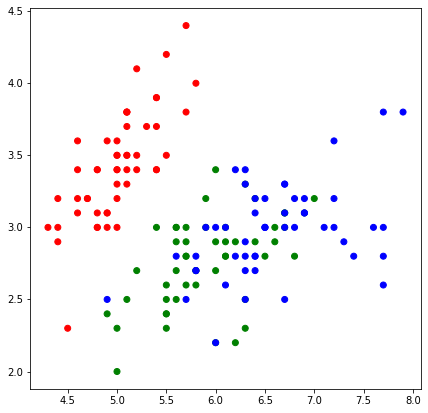

In [8]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [9]:
%%time
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.733
CPU times: user 41.9 ms, sys: 2.89 ms, total: 44.8 ms
Wall time: 49 ms


In [10]:
%%time
k = 5

y_pred_m = knn_matrix(X_train, y_train, X_test, k)

print(f'Точность модифицированного алгоритма при k = {k}: {accuracy(y_pred_m, y_test):.3f}')

Точность модифицированного алгоритма при k = 5: 0.733
CPU times: user 3.18 ms, sys: 1.91 ms, total: 5.09 ms
Wall time: 4.24 ms


Результаты совпадают, но модифицированный алгоритм работает намного быстрее. Однако стоит заметить, что результаты двух алгоритмов не всегда совпадают идеально. Рассмотрим модель, в которой участвут большое количество соседей - `k=10`.

In [11]:
%%time
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.767
CPU times: user 45.3 ms, sys: 2.33 ms, total: 47.6 ms
Wall time: 51 ms


In [12]:
%%time
k = 10

y_pred_m = knn_matrix(X_train, y_train, X_test, k)

print(f'Точность модифицированного алгоритма при k = {k}: {accuracy(y_pred_m, y_test):.3f}')

Точность модифицированного алгоритма при k = 10: 0.733
CPU times: user 3.82 ms, sys: 2.26 ms, total: 6.08 ms
Wall time: 8.37 ms


Разница связана с тем, что расстояния до некоторых точек обучающего набора совпадают, в то время как они принадлежат разным классам. Это хорошо видно на примере ниже.

In [13]:
x_train = X_train
x_test = X_test
train_size = x_train.shape[0]
test_distances = np.sum(x_test**2, axis=1) + \
    np.sum(x_train**2,axis=1).reshape(train_size, 1) - 2*x_train@x_test.T
# В некоторых случаях из-за особенностей вычислений и округлений могут получаться очень маленькие, 
# но при этом отрицательные значения. Заменим их нулями
test_distances[test_distances < 0] = 0 
test_distances = np.sqrt(test_distances)

np.array(sorted(np.concatenate((test_distances[:, 13].reshape(120, 1), 
                                y_train.reshape(120, 1)), axis=1), key=lambda x:x[0]))[:13]


array([[0.        , 2.        ],
       [0.2       , 1.        ],
       [0.31622777, 1.        ],
       [0.41231056, 2.        ],
       [0.42426407, 2.        ],
       [0.42426407, 1.        ],
       [0.4472136 , 1.        ],
       [0.5       , 1.        ],
       [0.5       , 1.        ],
       [0.5       , 1.        ],
       [0.53851648, 1.        ],
       [0.53851648, 1.        ],
       [0.53851648, 2.        ]])

Напоследок посмотрим на результаты работы двух версий алгоритмов на графиках.

(2352, 2)


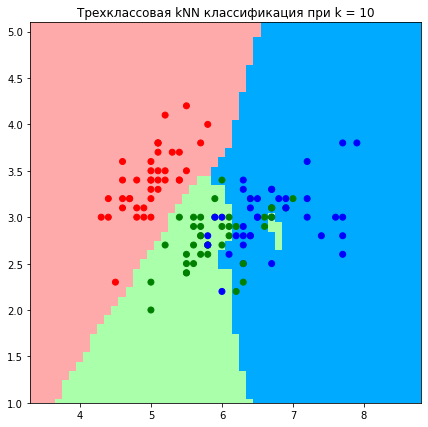

CPU times: user 2.93 s, sys: 30.8 ms, total: 2.96 s
Wall time: 3.02 s


In [14]:
%%time
get_graph(X_train, y_train, k, knn)

(2352, 2)


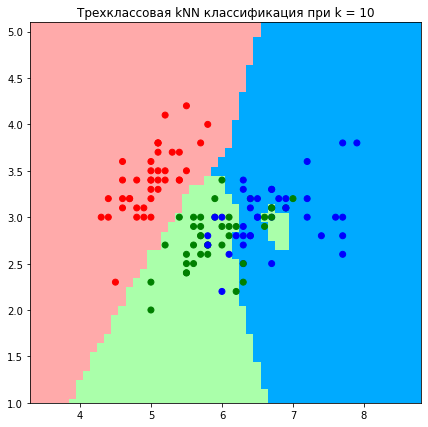

CPU times: user 296 ms, sys: 31.5 ms, total: 327 ms
Wall time: 285 ms


In [15]:
%%time
get_graph(X_train, y_train, k, knn_matrix)

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

Реализуем функцию, которая задает веса для соседей в соответствии с формулой: $w(d) = q^{d}$,   $q \in (0,1)$.

In [16]:
def weight_function(distances, q=0.5):
    return q ** distances

In [17]:
from collections import defaultdict

def knn_weighted(x_train, y_train, x_test, k):
    
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    test_distances = np.sum(x_test**2, axis=1) + \
        np.sum(x_train**2,axis=1).reshape(train_size, 1) - 2*x_train@x_test.T
    # В некоторых случаях из-за особенностей вычислений и округлений могут получаться очень маленькие, 
    # но при этом отрицательные значения. Заменим их нулями
    test_distances[test_distances < 0] = 0 
    test_distances = np.sqrt(test_distances)
    
    # Найдем индексы, которые обеспечат сортировку значений матрицы по столбцам и отберем первые k из них
    ind = np.argsort(test_distances, axis=0)[:k]
    sorted_distances = weight_function(np.sort(test_distances.T, axis=1)[:, :k])
    classes = y_train[ind].T
                  
    # Не придумал, как оптимизировать эту часть, где создаем словарь с классами
    classes_with_distances = np.array([dict()] * test_size)
    for i in range(classes.shape[0]):
        data = defaultdict(float)
        for j in range(classes.shape[1]):
            data[classes[i][j]] += sorted_distances[i, j]
            classes_with_distances[i] = data
    
    answers = np.array([max(classes_with_distances[i], key=classes_with_distances[i].get) 
                        for i in range(test_size)])
                                       
    return answers

Проведем классификацию с использованием написанного алгоритма, учитывающего веса соседей.

In [18]:
%%time
k = 10

y_pred_w = knn_weighted(X_train, y_train, X_test, k)

print(f'Точность алгоритма с весами при k = {k}: {accuracy(y_pred_w, y_test):.3f}')

Точность алгоритма с весами при k = 10: 0.733
CPU times: user 1.88 ms, sys: 423 µs, total: 2.31 ms
Wall time: 3 ms


Как видим мера точности представленной реализации в данной задаче совпадает со значением, полученным ранее для матричной вариации kNN. График, отражающий разделение классов изменился незначительно.

(2352, 2)


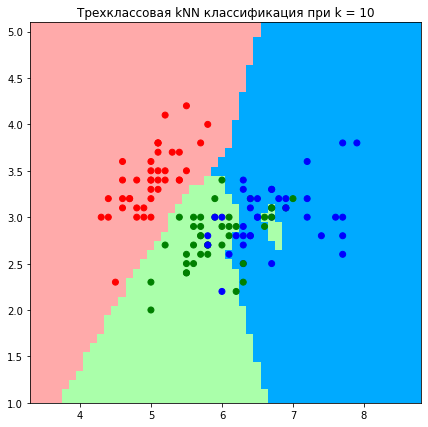

CPU times: user 264 ms, sys: 32.7 ms, total: 297 ms
Wall time: 245 ms


In [19]:
%%time
get_graph(X_train, y_train, k, knn_weighted)

2. *Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

Скопируем из лекции генерацию датасета и реализацию алгоритма K-means.

In [20]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, random_state=1)

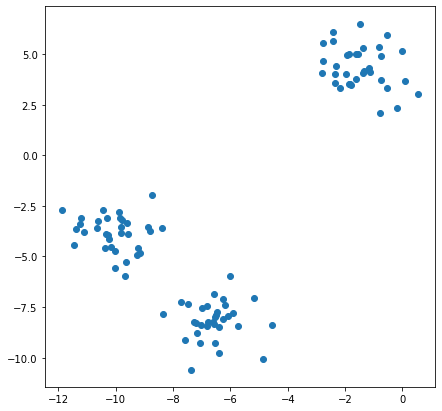

In [21]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [22]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

In [23]:
def visualize(centroids, clusters):
    colors = ['r', 'g', 'b', 'orange', 'y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for cluster_item in clusters:
        for x in clusters[cluster_item]:
            plt.scatter(x[0], x[1], color=colors[cluster_item])
            
    plt.show()

In [24]:
# определим максимальное количество итераций
max_iterations = 5

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

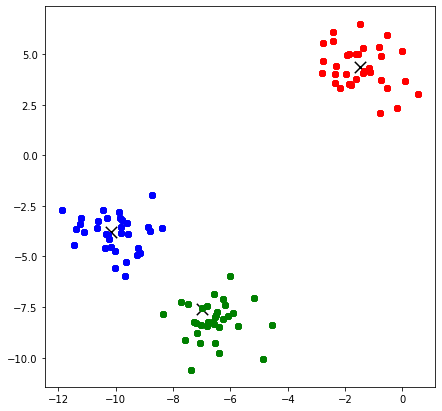

In [25]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

Напишем функцию, которая будет вычислять среднее квадратичное внутрикластерное расстояние.

In [26]:
def average_square_inter_cluster_distance(centroids, clusters):
    distance = 0
    for cluster in clusters:
        distance += np.sum((clusters[cluster] - centroids[cluster]) ** 2) / len(clusters[cluster])
    return distance

Визуализируем изменения этого значения в зависимости от количества кластеров $k$.

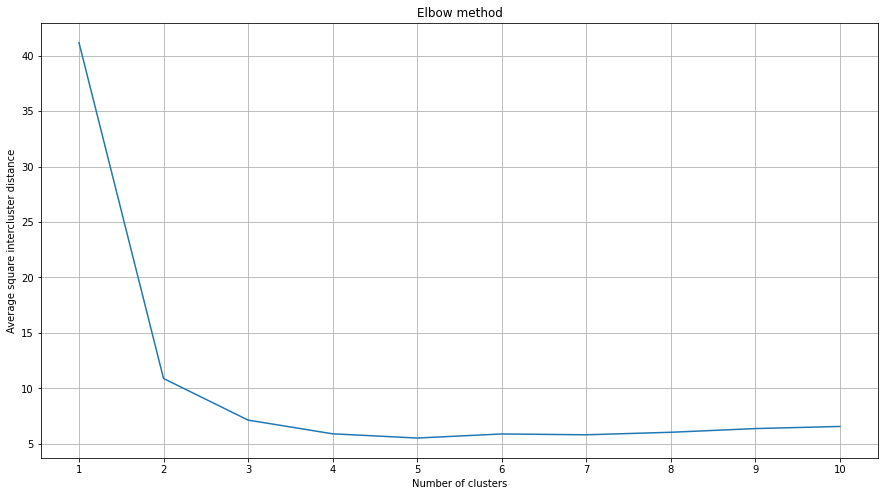

In [27]:
k = np.arange(1, 11)
distances = [average_square_inter_cluster_distance(*kmeans(X, value, max_iterations, min_distance)) for value in k]

plt.figure(figsize=(15,8))
plt.xlabel('Number of clusters')
plt.ylabel('Average square intercluster distance')
plt.title('Elbow method')
plt.grid()
plt.xticks(k)
plt.plot(k, distances)
plt.show()

Данный график позволяет заметить, что при увеличении количества кластеров больше 3 значение среднего квадратичного внутрикластерного расстояния сокращается незначительно, а в определенный момент даже начинает снова расти. Значит, в соответствии с методом локтя, оптимальное количество кластеров для данной задачи равно 3.